# Speaker Diarization using Features

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization-features](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization-features).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### What is the different with Speaker Diarization

Current speaker diarization, https://malaya-speech.readthedocs.io/en/latest/load-diarization.html

Required a pipeline, VAD -> Group positive VADs -> Speaker models -> Clustering, and this pipeline required a really good VAD and Speaker models. What if we can directly cluster using STFT / Features and arange the timestamp.

Inspired by [khursani8](https://github.com/khursani8),

Wave -> STFT / Features -> Clustering -> arange timestamp.

The features can be anything, such as,

- MFCC
- Melspectrogram
- Conv

In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # to stop tensorflow form loading cuda
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt


### Load audio sample

In [21]:
y, sr = malaya_speech.load('../../../audio/conversations/2_speakers.en.wav')
len(y), sr

(719710, 16000)

In [3]:
# just going to take 60 seconds
# y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Generate Log Melspectrogram

You can use interface `malaya_speech.utils.featurization.STTFeaturizer`,

```python
class STTFeaturizer:
    def __init__(
        self,
        sample_rate=16000,
        frame_ms=25,
        stride_ms=10,
        nfft=None,
        num_feature_bins=80,
        feature_type='log_mel_spectrogram',
        preemphasis=0.97,
        dither=1e-5,
        normalize_signal=True,
        normalize_feature=True,
        norm_per_feature=True,
        **kwargs,
    ):
        """
        sample_rate: int, optional (default=16000)
        frame_ms: int, optional (default=25)
            To calculate `frame_length` for librosa STFT, `frame_length = int(sample_rate * (frame_ms / 1000))`
        stride_ms: int, optional (default=10)
            To calculate `frame_step` for librosa STFT, `frame_step = int(sample_rate * (stride_ms / 1000))`
        nfft: int, optional (default=None)
            If None, will calculate by `math.ceil(math.log2((frame_ms / 1000) * sample_rate))`
        num_feature_bins: int, optional (default=80)
            Size of output features.
        feature_type: str, optional (default='log_mel_spectrogram')
            Features type, allowed values:

            * ``'spectrogram'`` - np.square(np.abs(librosa.core.stft))
            * ``'mfcc'`` - librosa.feature.mfcc(np.square(np.abs(librosa.core.stft)))
            * ``'log_mel_spectrogram'`` - log(mel(np.square(np.abs(librosa.core.stft))))
        """
```

### Spectral Clustering

This is a Python re-implementation of the spectral clustering algorithm in the paper [Speaker Diarization with LSTM](https://google.github.io/speaker-id/publications/LstmDiarization/).

So, make sure you already install [spectralcluster](https://pypi.org/project/spectralcluster/),

```bash
pip install spectralcluster
```

In [33]:
from spectralcluster import SpectralClusterer,RefinementOptions
refinement_options = RefinementOptions(gaussian_blur_sigma=30.0,p_percentile=0.95)
clusterer = SpectralClusterer(
    min_clusters=1,
    max_clusters=5,
    refinement_options=refinement_options
)

#### Clustering on log MelSpectrogram

In [34]:
%%time

featurizer = malaya_speech.featurization.STTFeaturizer(feature_type = 'log_mel_spectrogram',
                                                      frame_ms = 50, stride_ms = 30)
features = featurizer(y)
features.shape

Wall time: 60 ms


(1500, 80)

In [35]:
from malaya_speech.utils.dist import l2_normalize

In [36]:
%%time

cluster_labels = clusterer.predict(l2_normalize(features))
frames = malaya_speech.arange.arange_frames(features, y, sr)
results = []
for no, result in enumerate(cluster_labels):
    results.append((frames[no], result))
grouped = malaya_speech.group.group_frames(results)

Wall time: 1.31 s


In [37]:
grouped

[(<malaya_speech.model.frame.Frame at 0x27bed587c48>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587c88>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587cc8>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587d08>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587d88>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587e08>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587e48>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587d48>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587e88>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587dc8>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587ec8>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587f08>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587f48>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bed587f88>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bed587fc8>, 1),
 (<malaya_speech.model.frame.Frame at 0x27bee1a8e08>, 0),
 (<malaya_speech.model.frame.Frame at 0x27bee1a8c08>, 1),
 (<malaya_spee

#### Clustering on TRILL

The TRILL model presented in "Towards Learning a Universal Non-Semantic Representation of Speech". It exceeds state-of-the-art performance on a number of transfer learning tasks drawn from the non-semantic speech domain (speech emotion recognition, language identification, etc). It is trained on publicly-available AudioSet, https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3

In [8]:
import tensorflow_hub as hub
module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3')

In [47]:
# i think 60ms pretty ok
frames = malaya_speech.generator.frames(y, frame_duration_ms = 30)
len(frames)

2000

In [48]:
from tqdm import tqdm

arrays = [f.array for f in frames]
embeddings = []
for i in tqdm(range(len(arrays))):
    e = module(arrays[i], sample_rate=16000)['embedding']
    embeddings.append(e)

100%|██████████| 2000/2000 [01:02<00:00, 32.23it/s]


In [49]:
concat = np.concatenate(embeddings, axis = 0)
concat.shape

(2000, 512)

In [65]:
clusterer = SpectralClusterer(
    min_clusters=1,
    max_clusters=100,
    p_percentile=0.95,
    gaussian_blur_sigma=1.0,
    thresholding_soft_multiplier = 1.0,
)

In [66]:
%%time

cluster_labels = clusterer.predict(l2_normalize(concat))
frames = malaya_speech.arange.arange_frames(concat, y, sr)
results_trill = []
for no, result in enumerate(cluster_labels):
    results_trill.append((frames[no], result))
grouped_trill = malaya_speech.group.group_frames(results_trill)
grouped_trill

CPU times: user 16.1 s, sys: 1.43 s, total: 17.5 s
Wall time: 4.28 s


[(<malaya_speech.model.frame.Frame at 0x16dacc210>, 0)]

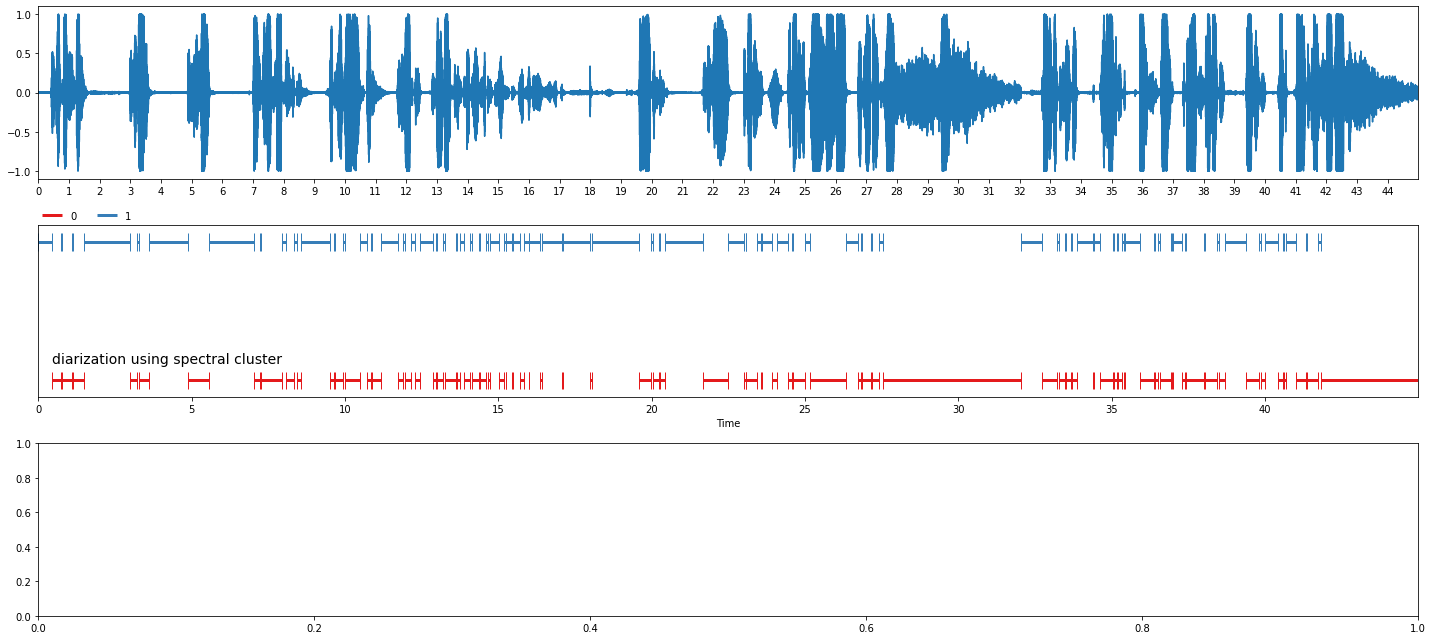

In [49]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
min_timestamp = min([i[0].timestamp for i in grouped])
max_timestamp = max([i[0].timestamp + i[0].duration for i in grouped])
ax[0].set_xlim((min_timestamp, max_timestamp))
ax[0].set_xticks(np.arange(0, 45, 1.0))
ax[0].plot([i / sr for i in range(len(y))], y)
malaya_speech.extra.visualization.plot_classification(grouped, 
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
# malaya_speech.extra.visualization.plot_classification(grouped_trill, 
#                                                       'diarization using spectral cluster TRILL', ax = ax[2],
#                                                      x_text = 0.01)
fig.tight_layout()
plt.show()

In [17]:
import IPython.display as ipd

ipd.Audio(grouped[0][0].array, rate = sr)

In [18]:
ipd.Audio(grouped[1][0].array, rate = sr)

In [70]:
ipd.Audio(grouped[2][0].array, rate = sr)

In [71]:
ipd.Audio(grouped[3][0].array, rate = sr)